In [1]:
import cv2
import numpy as np

In [2]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[2]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[1]
    print('Starting sliding window {} from {}, {} to {}, {}'.format(xy_window, x_start_stop[0], y_start_stop[0], x_start_stop[1], y_start_stop[1]))
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    print('Finished with {} windows to slide'.format(len(window_list)))
    return window_list

In [3]:
def search_windows(prediction_method, img, windows, xy_window=(64, 64)):
    print('Starting to search {} windows'.format(len(windows)))
    on_windows = []
    for window in windows:
        crop_img = cv2.resize(img[0][window[0][1]:window[1][1], window[0][0]:window[1][0]], (224, 224))
        crop_img = np.expand_dims(crop_img, axis=0)
        prediction = prediction_method(crop_img)
        if prediction:
            on_windows.append(window)
            print('Found window: {}'.format({window}))

    print('Finished searching windows with {} results'.format(len(on_windows)))
    return on_windows

# Testing With ImageNet Weights

In [4]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image

def dog_detector(img):
    preprocessed_img = preprocess_input(img)
    prediction = np.argmax(ResNet50_model.predict_on_batch(preprocessed_img))
    return ((prediction <= 268) & (prediction >= 151))

def path_to_tensor(img_path):    
    img = image.load_img(img_path)
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

Using TensorFlow backend.


In [5]:
from keras.applications.resnet50 import ResNet50

ResNet50_model = ResNet50(weights='imagenet')

In [6]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [7]:
test_img = path_to_tensor('dog-walk.jpg')
windows = slide_window(test_img, xy_window=(100,200))
on_windows = search_windows(dog_detector, test_img, windows)

Starting sliding window (100, 200) from 0, 0 to 2000, 1000
Finished with 351 windows to slide
Starting to search 351 windows
Found window: {((1550, 0), (1650, 200))}
Found window: {((350, 100), (450, 300))}
Found window: {((1550, 100), (1650, 300))}
Found window: {((200, 200), (300, 400))}
Found window: {((700, 200), (800, 400))}
Found window: {((750, 200), (850, 400))}
Found window: {((900, 200), (1000, 400))}
Found window: {((950, 200), (1050, 400))}
Found window: {((1000, 200), (1100, 400))}
Found window: {((1050, 200), (1150, 400))}
Found window: {((1100, 200), (1200, 400))}
Found window: {((1150, 200), (1250, 400))}
Found window: {((1200, 200), (1300, 400))}
Found window: {((1700, 200), (1800, 400))}
Found window: {((650, 300), (750, 500))}
Found window: {((700, 300), (800, 500))}
Found window: {((850, 300), (950, 500))}
Found window: {((900, 300), (1000, 500))}
Found window: {((950, 300), (1050, 500))}
Found window: {((1000, 300), (1100, 500))}
Found window: {((1600, 300), (1700,

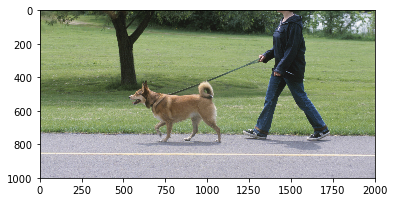

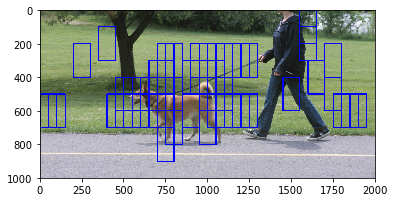

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

out_img = mpimg.imread('dog-walk.jpg')
drawn_img = draw_boxes(out_img.copy(), on_windows)
plt.imshow(out_img)
plt.show()
plt.imshow(drawn_img)
plt.show()

In [9]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [10]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [11]:
def draw_labeled_bboxes(img, labels):
    bbox_list = []
    for label_number in range(1, labels[1]+1):
        nonzero_index = (labels[0] == label_number).nonzero()
        # Identify x and y values of those pixels
        nonzero_y = np.array(nonzero_index[0])
        nonzero_x = np.array(nonzero_index[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzero_x), np.min(nonzero_y)), (np.max(nonzero_x), np.max(nonzero_y)))
        bbox_list.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, bbox_list

In [12]:
from scipy.ndimage.measurements import label

print(out_img.shape)
print(type(out_img))
heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
print(heat.shape)
heat = add_heat(heat, on_windows)
heat_thresh = apply_threshold(heat, 1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
print(labels[1])
heat_img, heat_boxes = draw_labeled_bboxes(out_img.copy(), labels)

(1000, 2000, 3)
<class 'numpy.ndarray'>
(1000, 2000)
5


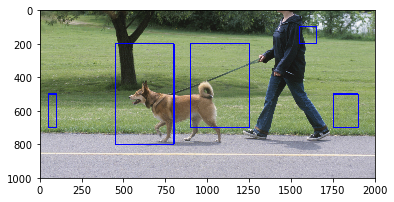

In [13]:
plt.imshow(heat_img)
plt.show()

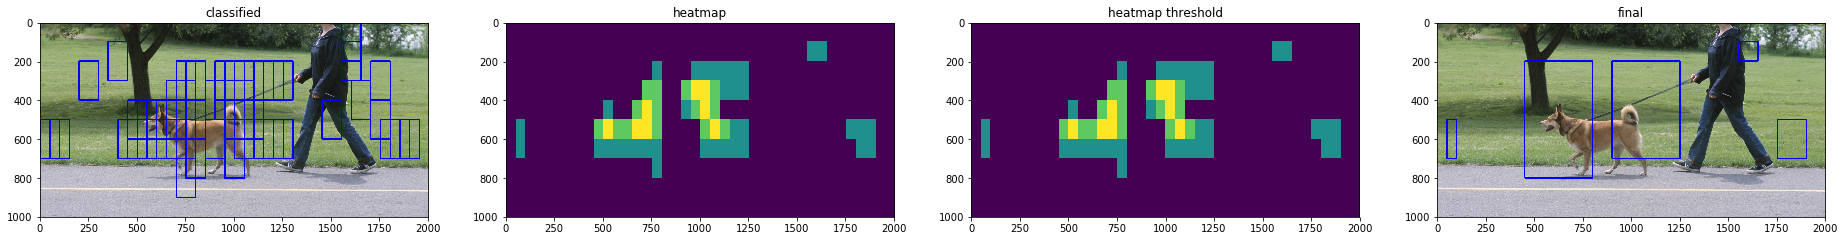

In [14]:
plt.figure(figsize=(32,16))
plt.subplot(1, 4, 1)
plt.title('classified')
plt.imshow(drawn_img)
plt.subplot(1, 4, 2)
plt.title('heatmap')
plt.imshow(heat)
plt.subplot(1, 4, 3)
plt.title('heatmap threshold')
plt.imshow(heat_thresh)
plt.subplot(1, 4, 4)
plt.title('final')
plt.imshow(heat_img)
plt.show()

In [15]:
from sliding_window import heatmap_windows

heat_img2, heat_boxes2 = heatmap_windows(out_img, on_windows, 1)
print(heat_boxes2)

[((1550, 100), (1649, 199)), ((450, 200), (799, 799)), ((900, 200), (1249, 699)), ((50, 500), (99, 699)), ((1750, 500), (1899, 699))]
